In [2]:
print("Hello World")

Hello World


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter

## Loading Dataset

In [2]:

# Try reading the CSV file with a different encoding
try:
    store = pd.read_csv("Sample-Superstore.csv", encoding='latin-1')
except UnicodeDecodeError:
    print("Error: Unable to read the file with 'latin-1' encoding.")
    try:
        store = pd.read_csv("Sample-Superstore.csv", encoding='utf-16')
    except UnicodeDecodeError:
        print("Error: Unable to read the file with 'utf-16' encoding.")

## Renaming features

In [3]:

## renaming of the columns to get rid of the space in between column names 
store.rename(columns={"Row ID":"RowID","Order ID": "OrderID", "Order Date": "OrderDate", "Ship Date": "ShipDate", "Ship Mode": "ShipMode", "Customer ID": "CustomerID", "Customer Name": "CustomerName", "Postal Code": "PostalCode", "Product ID": "ProductID","Sub-Category":"SubCategory", "Product Name": "ProductName"}, inplace=True)


In [22]:
#We need to fix OrderDate and ship date to be YYYY/MM/DD (can be ordered easily even when seen as a string). 
store[['OrderDate','ShipDate']] = store[['OrderDate','ShipDate']].apply(pd.to_datetime)

## Creation of new Dataframe

In [ ]:
"""""
Creating Dataframe for different Parameters.

The paramaters includes:
                        Monetary (amount of money spent)
                        Frequency (how frequently the customer bought something)
                        Recency (how many days has passed from last date to their last purchase)

"""

In [41]:

store_monetary = store.groupby('CustomerID', as_index=False)['Sales'].sum()
##renaming sales column to Amount
store_monetary.rename(columns={"Sales":"Amount"},inplace=True)
store_monetary.head()

,CustomerID,Amount
0,AA-10315,5563.560
1,AA-10375,1056.390
2,AA-10480,1790.512
3,AA-10645,5086.935
4,AB-10015,886.156


In [40]:
store_monetary.head()

,CustomerID,Amount
0,AA-10315,5563.560
1,AA-10375,1056.390
2,AA-10480,1790.512
3,AA-10645,5086.935
4,AB-10015,886.156


In [21]:
store_frequency = store.groupby('CustomerID', as_index=False)['OrderID'].count()
store_frequency

,CustomerID,OrderID
0,AA-10315,11
1,AA-10375,15
2,AA-10480,12
3,AA-10645,18
4,AB-10015,6
...,...,...
788,XP-21865,28
789,YC-21895,8
790,YS-21880,12
791,ZC-21910,31


In [ ]:
store_recency = store.groupby('CustomerID', as_index=False)['Sales'].sum()
store_recency.head()

In [31]:

# Find the last order date in the dataset
reference_date = store['OrderDate'].max()

# Calculate the Recency for each customer
store_recency = store.groupby('CustomerID')['OrderDate'].max().reset_index()
store_recency['Recency'] = (reference_date - store_recency['OrderDate']).dt.days

# Display the first few rows of the resulting DataFrame

store_recency.head()

,CustomerID,OrderDate,Recency
0,AA-10315,2017-06-29,184
1,AA-10375,2017-12-11,19
2,AA-10480,2017-04-15,259
3,AA-10645,2017-11-05,55
4,AB-10015,2016-11-10,415


In [42]:

# Rename columns in store_frequency to match 'CustomerID' for merging
store_frequency = store.groupby('CustomerID')['OrderID'].count().reset_index(name='Frequency')

# Merge the dataframes
parameters = pd.merge(store_monetary, store_frequency, on='CustomerID')
parameters = pd.merge(parameters, store_recency[['CustomerID', 'Recency']], on='CustomerID')

# Display the first few rows of the resulting DataFrame
parameters.head()

,CustomerID,Amount,Frequency,Recency
0,AA-10315,5563.560,11,184
1,AA-10375,1056.390,15,19
2,AA-10480,1790.512,12,259
3,AA-10645,5086.935,18,55
4,AB-10015,886.156,6,415


In [43]:
parameters.head()

,CustomerID,Amount,Frequency,Recency
0,AA-10315,5563.560,11,184
1,AA-10375,1056.390,15,19
2,AA-10480,1790.512,12,259
3,AA-10645,5086.935,18,55
4,AB-10015,886.156,6,415


## Visualization of Outliers

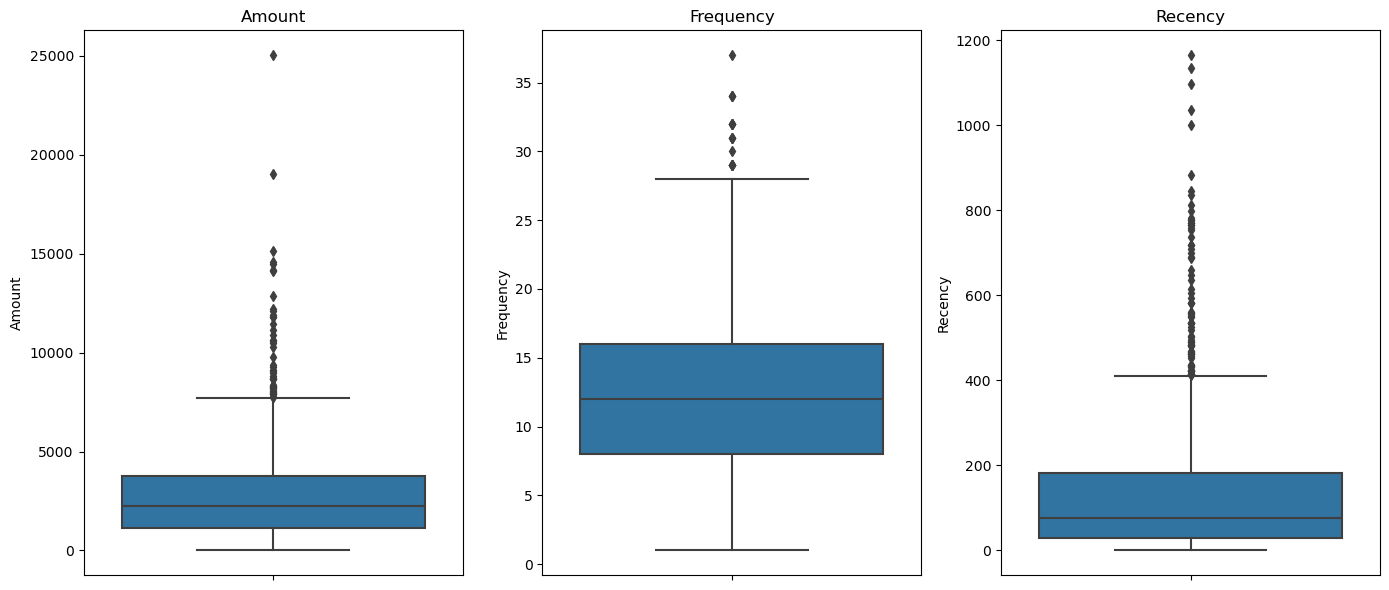

In [55]:


# Create boxplots for Amount, Frequency, and Recency
plt.figure(figsize=(14, 6))

# Amount boxplot
plt.subplot(1, 3, 1)
sns.boxplot(y=parameters['Amount'])
plt.title('Amount')

# Frequency boxplot
plt.subplot(1, 3, 2)
sns.boxplot(y=parameters['Frequency'])
plt.title('Frequency')

# Recency boxplot
plt.subplot(1, 3, 3)
sns.boxplot(y=parameters['Recency'])
plt.title('Recency')

plt.tight_layout()
plt.show()


## Outliers Identification and Removal 

In [50]:
# Function to calculate IQR and filter out outliers
#def remove_outliers_iqr(df, column):
    #Q1 = df[column].quantile(0.25)
    #Q3 = df[column].quantile(0.75)
    #IQR = Q3 - Q1
    #lower_bound = Q1 - 1.5 * IQR
    #upper_bound = Q3 + 1.5 * IQR
    #return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the function to each column
#parameters_cleaned = parameters.copy()
#for column in ['Amount', 'Frequency', 'Recency']:
    #parameters_cleaned = remove_outliers_iqr(parameters_cleaned, column)




##Alternatively


# Function to calculate IQR and filter out outliers
def remove_outliers_iqr(parameters, column):
    Q1 = parameters[column].quantile(0.25)
    Q3 = parameters[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return parameters[(parameters[column] >= lower_bound) & (parameters[column] <= upper_bound)]

# Apply the function to each column
parameters_cleaned = parameters.copy()
for column in ['Amount', 'Frequency', 'Recency']:
    parameters_cleaned = remove_outliers_iqr(parameters_cleaned, column)

parameters_cleansed=parameters_cleaned.reset_index(drop=True)


In [51]:
parameters_cleansed

,CustomerID,Amount,Frequency,Recency
0,AA-10315,5563.560,11,184
1,AA-10375,1056.390,15,19
2,AA-10480,1790.512,12,259
3,AA-10645,5086.935,18,55
4,AB-10015,886.156,6,415
...,...,...,...,...
658,VS-21820,1055.981,8,221
659,VW-21775,6134.038,18,28
660,YC-21895,5454.350,8,4
661,YS-21880,6720.444,12,9


## Feature Scaling

In [ ]:
"""
Using Standardisation Scaling
"""

In [69]:
# Rescaling the attributes
parameters_clean = parameters_cleansed[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
parameters_scaled = scaler.fit_transform(parameters_clean)
parameters_scaled.shape

parameters_scaled = pd.DataFrame(parameters_scaled)
parameters_scaled.columns = ['Amount', 'Frequency', 'Recency']
parameters_scaled.head()

,Amount,Frequency,Recency
0,1.841594,-0.231602,0.826249
1,-0.851013,0.535200,-0.811889
2,-0.412445,-0.039901,1.570857
3,1.556856,1.110301,-0.454477
4,-0.952712,-1.190104,3.119642


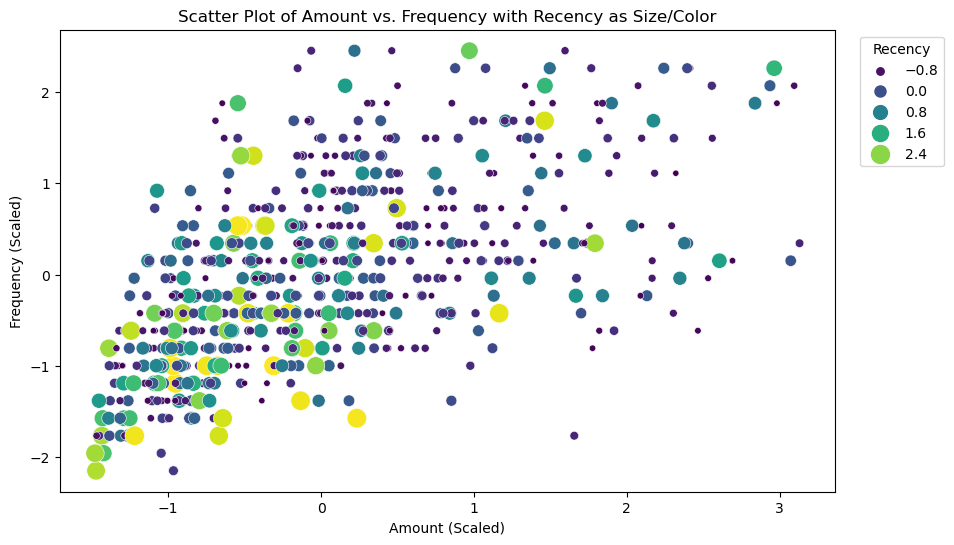

In [64]:

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Use seaborn scatter plot to include Recency as the color
scatter = sns.scatterplot(
    data=parameters_scaled, 
    x='Amount', 
    y='Frequency', 
    size='Recency', 
    hue='Recency',
    palette='viridis', 
    sizes=(20, 200), 
    legend='brief'
)

# Add labels and title
plt.xlabel('Amount (Scaled)')
plt.ylabel('Frequency (Scaled)')
plt.title('Scatter Plot of Amount vs. Frequency with Recency as Size/Color')
plt.legend(title='Recency', loc='upper right', bbox_to_anchor=(1.15, 1))

# Show the plot
plt.show()


## Building the Model

In [58]:
"""Here 4 is randomly selected as number of clusters"""

'Here 4 is randomly selected as number of clusters'

In [70]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
# Fit K-Means clustering
kmeans.fit(parameters_scaled)


c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [72]:
# Assign cluster labels to each data point
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

[(0, 203), (1, 246), (2, 107), (3, 107)]

In [78]:
kmeans.cluster_centers_

array([[ 0.18357285,  0.66174109, -0.44758085],
       [-0.68467531, -0.76228487, -0.34417787],
       [ 1.73737329,  0.97772338, -0.24264617],
       [-0.51153368, -0.48063333,  1.88308234]])

In [ ]:
"""Visualizing the cnetroids"""

C:\Users\godwi\AppData\Local\Temp\ipykernel_23232\1666062005.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(


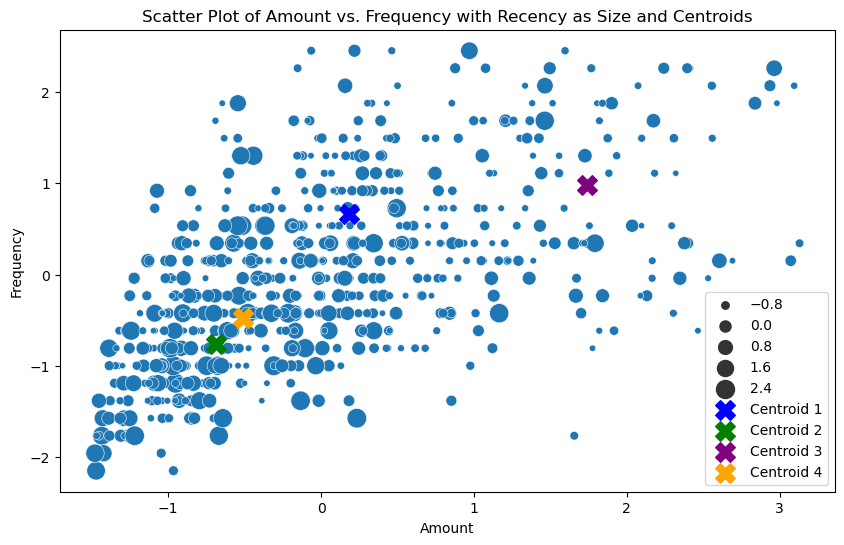

In [81]:

# Update the centroids
centroids = [[0.18357285, 0.66174109, -0.44758085],
             [-0.68467531, -0.76228487, -0.34417787],
             [1.73737329, 0.97772338, -0.24264617],
             [-0.51153368, -0.48063333, 1.88308234]]

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Use seaborn scatter plot to include Recency as the color
scatter = sns.scatterplot(
    data=parameters_scaled, 
    x='Amount', 
    y='Frequency', 
    size='Recency', 
    legend='brief',
    palette='viridis',
    sizes=(20, 200)
)

# Plot centroids with different colors
colors = ['blue', 'green', 'purple', 'orange']
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], marker='X', s=200, c=colors[i], label=f'Centroid {i+1}')

# Add labels and title
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Scatter Plot of Amount vs. Frequency with Recency as Size and Centroids')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
"""""Visualizing the Clusters"""

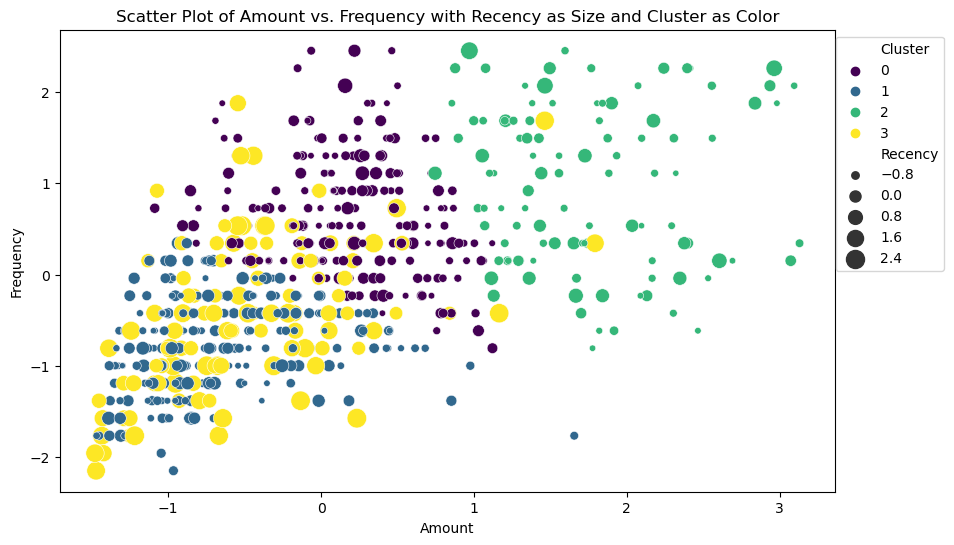

In [76]:

# Optionally, add the cluster labels to the DataFrame for further analysis
#parameters_scaled['Cluster'] = label_list

# Display the DataFrame with cluster labels
#print(parameters_scaled)

# Create a scatter plot to visualize the clusters
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=parameters_scaled, 
    x='Amount', 
    y='Frequency', 
    hue='Cluster', 
    palette='viridis', 
    size='Recency', 
    sizes=(20, 200), 
    legend='brief'
)

# Add labels and title
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Scatter Plot of Amount vs. Frequency with Recency as Size and Cluster as Color')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Show the plot
plt.show()


In [82]:
kmeans.labels_

array([2, 0, 3, 2, 3, 1, 0, 1, 1, 3, 2, 0, 3, 2, 0, 3, 3, 1, 1, 1, 0, 0,
       1, 2, 1, 0, 0, 1, 2, 3, 1, 2, 2, 2, 1, 1, 1, 2, 0, 1, 1, 1, 2, 2,
       1, 0, 1, 0, 3, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 0, 2, 0, 3, 0, 1, 1,
       1, 3, 0, 1, 3, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 3, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 3, 3, 3, 1, 0, 3, 3, 2, 3, 0, 3, 0, 1,
       0, 1, 2, 1, 2, 0, 0, 1, 0, 0, 1, 1, 1, 3, 1, 3, 3, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 3, 2, 2, 2, 1, 1, 1, 1, 1, 0, 3, 0, 0, 1, 2, 0, 3, 0,
       1, 0, 3, 0, 3, 2, 0, 0, 2, 3, 3, 0, 1, 1, 0, 1, 1, 1, 2, 0, 1, 2,
       1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1, 2, 0, 3, 1, 1, 0, 0, 3, 2, 0, 0,
       1, 0, 1, 2, 1, 3, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 3, 3, 1,
       0, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 3, 1, 2, 0, 0, 3, 1, 2, 3,
       2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 1, 0, 0, 0, 3, 1, 2, 0, 0, 1, 0,
       2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 2, 3, 1, 1, 2, 1, 1, 2,
       3, 3, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 3, 3, 2,

## Finding the optimal number of clusters (Evaluation Metrics)

### Elbow Method